In [34]:
import pandas
from tinydb import TinyDB
import numpy
import matplotlib.pyplot as mat
import seaborn as sea

data = pandas.DataFrame(TinyDB('data/db/db.json').table('games').all())
print(data.head())
print(data.shape)

    app_id                               name          category  \
0   536280                     Disintegration      Action Games   
1   982800                        Moon Tycoon  Simulation Games   
2   767960                           Math RTS    Strategy Games   
3  1368670  Beach Volleyball Competition 2020      Sports Games   
4   977800          At Home Alone - Reward 5$   Adventure Games   

                                                tags  \
0  [FPS, PvE, Vehicular Combat, RTS, Shooter, Str...   
1  [Strategy, Simulation, Indie, Management, Sing...   
2  [Strategy, Indie, Education, RTS, Real-Time, S...   
3  [Sports, Action, Arcade, Character Action Game...   
4  [Strategy, Adventure, Free to Play, RPG, Indie...   

                                     reviews  \
0  {'overall': {'rating': 61, 'count': 120}}   
1           {'overall': 'need_more_reviews'}   
2           {'overall': 'need_more_reviews'}   
3           {'overall': 'need_more_reviews'}   
4           {'overal

In [3]:
# Replacing placeholder value in review data with NaN:
data.loc[(data['reviews'] == {'overall': 'need_more_reviews'}),'reviews'] = numpy.nan
# Splitting review data into overall and recent:
data = pandas.concat([data.drop(['reviews'], axis=1), data['reviews'].apply(pandas.Series)], axis=1)
del data[0]
# Getting rid of recent review data as it is not needed:
del data["recent"]
print(data.head())

    app_id                               name          category  \
0   536280                     Disintegration      Action Games   
1   982800                        Moon Tycoon  Simulation Games   
2   767960                           Math RTS    Strategy Games   
3  1368670  Beach Volleyball Competition 2020      Sports Games   
4   977800          At Home Alone - Reward 5$   Adventure Games   

                                                tags  \
0  [FPS, PvE, Vehicular Combat, RTS, Shooter, Str...   
1  [Strategy, Simulation, Indie, Management, Sing...   
2  [Strategy, Indie, Education, RTS, Real-Time, S...   
3  [Sports, Action, Arcade, Character Action Game...   
4  [Strategy, Adventure, Free to Play, RPG, Indie...   

                                         playtracker  \
0  {'popularity': 2, 'estimated_players': 159000,...   
1                                                NaN   
2                                                NaN   
3                                   

In [4]:
# Splitting overall review data into two columns:
data = pandas.concat([data.drop(['overall'], axis=1), data['overall'].apply(pandas.Series)], axis=1)
del data[0]
data.rename(columns = {'count':'review_count'}, inplace = True)
print(data.head())

    app_id                               name          category  \
0   536280                     Disintegration      Action Games   
1   982800                        Moon Tycoon  Simulation Games   
2   767960                           Math RTS    Strategy Games   
3  1368670  Beach Volleyball Competition 2020      Sports Games   
4   977800          At Home Alone - Reward 5$   Adventure Games   

                                                tags  \
0  [FPS, PvE, Vehicular Combat, RTS, Shooter, Str...   
1  [Strategy, Simulation, Indie, Management, Sing...   
2  [Strategy, Indie, Education, RTS, Real-Time, S...   
3  [Sports, Action, Arcade, Character Action Game...   
4  [Strategy, Adventure, Free to Play, RPG, Indie...   

                                         playtracker  review_count  rating  
0  {'popularity': 2, 'estimated_players': 159000,...         120.0    61.0  
1                                                NaN           NaN     NaN  
2                            

In [5]:
# Splitting playtracker into multiple columns:
data = pandas.concat([data.drop(['playtracker'], axis=1), data['playtracker'].apply(pandas.Series)], axis=1)
del data[0]
print(data.head())

    app_id                               name          category  \
0   536280                     Disintegration      Action Games   
1   982800                        Moon Tycoon  Simulation Games   
2   767960                           Math RTS    Strategy Games   
3  1368670  Beach Volleyball Competition 2020      Sports Games   
4   977800          At Home Alone - Reward 5$   Adventure Games   

                                                tags  review_count  rating  \
0  [FPS, PvE, Vehicular Combat, RTS, Shooter, Str...         120.0    61.0   
1  [Strategy, Simulation, Indie, Management, Sing...           NaN     NaN   
2  [Strategy, Indie, Education, RTS, Real-Time, S...           NaN     NaN   
3  [Sports, Action, Arcade, Character Action Game...           NaN     NaN   
4  [Strategy, Adventure, Free to Play, RPG, Indie...           NaN     NaN   

   average_playtime  estimated_active_players  estimated_players  popularity  
0               0.6                   25000.0    

In [6]:
# Splitting the dataset into two to make operations for tags easier:
game_info = data.copy()
del game_info['tags']
tags = pandas.DataFrame(data['tags'])
# Creating a column for each tag:
tags = pandas.concat([tags.drop(['tags'], axis=1), tags['tags'].apply(pandas.Series)], axis=1)
tags = pandas.get_dummies(tags)
tags.rename(columns=lambda x: x.split("_")[1], inplace=True)
tags = tags.groupby(level=0, axis=1).sum()
print(game_info.head())
print(tags.head())

    app_id                               name          category  review_count  \
0   536280                     Disintegration      Action Games         120.0   
1   982800                        Moon Tycoon  Simulation Games           NaN   
2   767960                           Math RTS    Strategy Games           NaN   
3  1368670  Beach Volleyball Competition 2020      Sports Games           NaN   
4   977800          At Home Alone - Reward 5$   Adventure Games           NaN   

   rating  average_playtime  estimated_active_players  estimated_players  \
0    61.0               0.6                   25000.0           159000.0   
1     NaN               NaN                       NaN                NaN   
2     NaN               NaN                       NaN                NaN   
3     NaN               NaN                       NaN                NaN   
4     NaN               NaN                       NaN                NaN   

   popularity  
0         2.0  
1         NaN  
2       

In [7]:
# Merging the tables back together:
games = game_info.merge(tags, left_index=True, right_index=True)
print(games.head())
print(games.shape)

    app_id                               name          category  review_count  \
0   536280                     Disintegration      Action Games         120.0   
1   982800                        Moon Tycoon  Simulation Games           NaN   
2   767960                           Math RTS    Strategy Games           NaN   
3  1368670  Beach Volleyball Competition 2020      Sports Games           NaN   
4   977800          At Home Alone - Reward 5$   Adventure Games           NaN   

   rating  average_playtime  estimated_active_players  estimated_players  \
0    61.0               0.6                   25000.0           159000.0   
1     NaN               NaN                       NaN                NaN   
2     NaN               NaN                       NaN                NaN   
3     NaN               NaN                       NaN                NaN   
4     NaN               NaN                       NaN                NaN   

   popularity  1980s  ...  Web Publishing  Well-Written 

In [8]:
# Checking if the tags seem right for tag "Strategy":
print(games["Strategy"].head())
# They seem to be right.

0    1
1    1
2    1
3    0
4    1
Name: Strategy, dtype: uint8


In [9]:
# Checking for nas:
pandas.set_option('display.max_rows', None)
print(games.isnull().sum())
# For more than half of the games review data is missing. For playtracker data even more.

app_id                                   0
name                                     0
category                                 0
review_count                         43741
rating                               43741
average_playtime                     56230
estimated_active_players             56230
estimated_players                    56230
popularity                           56230
1980s                                    0
1990's                                   0
2.5D                                     0
2D                                       0
2D Fighter                               0
2D Platformer                            0
360 Video                                0
3D                                       0
3D Fighter                               0
3D Platformer                            0
3D Vision                                0
4 Player Local                           0
4X                                       0
6DOF                                     0
ATV        

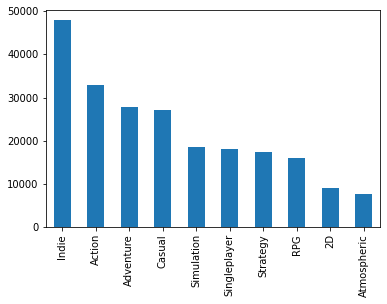

                                       0
Indie                              47956
Action                             32956
Adventure                          27811
Casual                             27098
Simulation                         18595
Singleplayer                       18180
Strategy                           17393
RPG                                15922
2D                                  8955
Atmospheric                         7604
Puzzle                              7333
Early Access                        7098
Free to Play                        6864
Multiplayer                         6334
Great Soundtrack                    6029
Story Rich                          6025
Violent                             5485
Fantasy                             5347
Pixel Graphics                      4863
Anime                               4804
Nudity                              4695
VR                                  4655
Difficult                           4615
Gore            

In [65]:
# Counting the occurences of tags:
tag_count = tags.sum()
tag_c = pandas.DataFrame(tag_count)
tag_c = tag_c.sort_values(by=0, ascending=False)
topten = tag_c.iloc[:10]
topten[0].plot(kind='bar')
mat.show()
print(tag_c)

['Action Games', 'Indie Games', 'Casual Games', 'Adventure Games', 'Simulation Games', 'RPG Games', 'Strategy Games', 'Free to Play Games', 'Racing Games', 'Sports Games']


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Action Games'),
  Text(1, 0, 'Simulation Games'),
  Text(2, 0, 'Strategy Games'),
  Text(3, 0, 'Sports Games'),
  Text(4, 0, 'Adventure Games'),
  Text(5, 0, 'Casual Games'),
  Text(6, 0, 'Indie Games'),
  Text(7, 0, 'RPG Games'),
  Text(8, 0, 'Racing Games'),
  Text(9, 0, 'Free to Play Games')])

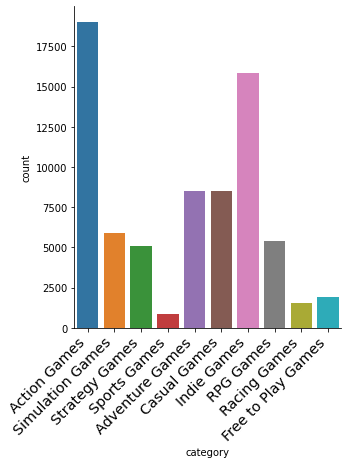

In [43]:
# Histogram of the 10 most common categories:
mc = games['category'].value_counts()[:10].index.tolist()
print(mc)
top_cat = games[(games['category'] == mc[0])|(games['category'] == mc[1])|(games['category'] == mc[2])|
                (games['category'] == mc[3])|(games['category'] == mc[4])|(games['category'] == mc[5])|
                (games['category'] == mc[6])|(games['category'] == mc[7])|(games['category'] == mc[8])|
                (games['category'] == mc[9])]
chart = sea.catplot(x='category', data=top_cat, kind='count')
mat.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)